In [1]:
import sys
import os # my addtion

import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import cebra.data
import torch
import cebra.integrations
import cebra.datasets
from cebra import CEBRA
import torch
import pickle
import utils
import seaborn as sns
import re

from matplotlib.collections import LineCollection
import pandas as pd

## QUICK SESSION STATS ANALYSIS

In [5]:
df_all_choice = pickle.load(open("/Users/brian.gitahi/Desktop/AIND/CEBRA/Git/CEBRA-Demo/all_session_stats_choice.pkl", "rb"))

In [6]:
df_all_choice

,subject_ID,ses_idx,all4_AUC_choice,DA_AUC_choice,NE_AUC_choice,5HT_AUC_choice,ACh_AUC_choice,b4_AUC_choice,af_AUC_choice,ses_idx_count
0,634704,634704_2022-08-31,0.998162,0.953547,0.975854,0.975771,0.940264,0.975688,0.988971,1
1,632110,632110_2022-08-10,1.000000,0.921269,0.961124,0.869761,0.953878,0.964747,0.954759,1
2,632106,632106_2022-10-28,0.500000,0.795429,0.908646,0.889115,0.807967,0.953383,0.917931,1
3,634704,634704_2022-09-01,0.995392,0.926250,0.974654,0.500000,0.959252,0.930858,0.983853,2
4,632110,632110_2022-08-11,0.991597,0.933757,0.917934,0.882247,0.978938,0.960004,0.976864,2
...,...,...,...,...,...,...,...,...,...,...
206,632106,632106_2022-10-20,0.952741,0.500000,0.721097,0.656238,0.732648,0.847366,0.874548,12
207,632106,632106_2022-10-24,0.983246,0.846930,0.914934,0.500000,0.843591,0.848845,0.923093,13
208,632106,632106_2022-10-25,0.975169,0.718124,0.866027,0.828422,0.500000,0.861373,0.578131,14
209,632106,632106_2022-10-21,0.945950,0.500000,0.763561,0.828547,0.816209,0.879587,0.907429,15


In [28]:
def plot_score_ind_nms(df, score='AUC'):

    all_auc_mean = df.loc[:,df.columns[df.columns.str.contains('^(all4)', regex=True)]].mean()[0]
    ind_nms_mean_auc = np.array(df.loc[:,df.columns[df.columns.str.contains('^(DA|NE|5HT|ACh)', regex=True)]].mean())

    b4_auc_mean = df.loc[:,df.columns[df.columns.str.contains('^(b4)', regex=True)]].mean()
    af_auc_mean = df.loc[:,df.columns[df.columns.str.contains('^(b4)', regex=True)]].mean()

    sns.stripplot(data=df.loc[:,df.columns[df.columns.str.contains('^(DA|NE|5HT|ACh)', regex=True)]])
    plt.plot(ind_nms_mean_auc, 'ko', label='individual mean auc score')
    plt.xlabel('Neuromodulator')
    plt.axhline(np.round(all_auc_mean,2), linestyle='--', c='k',label='combined dataset mean (All 4)')
    plt.ylabel('AUC Score')
    plt.title(f'Mean {score} scores across 211 sessions of Embeddings of Individual NMs')
    plt.legend()
    plt.show()

    return all_auc_mean
    # %%

/var/folders/zy/yd8f_r21629f1sr6zfh12jv40000gp/T/ipykernel_29895/4200864988.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  all_auc_mean = df.loc[:,df.columns[df.columns.str.contains('^(all4)', regex=True)]].mean()[0]
/var/folders/zy/yd8f_r21629f1sr6zfh12jv40000gp/T/ipykernel_29895/4200864988.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  ind_nms_mean_auc = np.array(df.loc[:,df.columns[df.columns.str.contains('^(DA|NE|5HT|ACh)', regex=True)]].mean())
/var/folders/zy/yd8f_r21629f1sr6zfh12jv40000gp/T/ipykernel_29895/4200864988.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  b4_auc_mean = df.loc[:,df.columns[df.columns.str.contains('^(b4)', regex=True)]].mean()
/var/folders/zy/yd8f_r21629f1sr6zfh12jv40000gp/T/ipyk

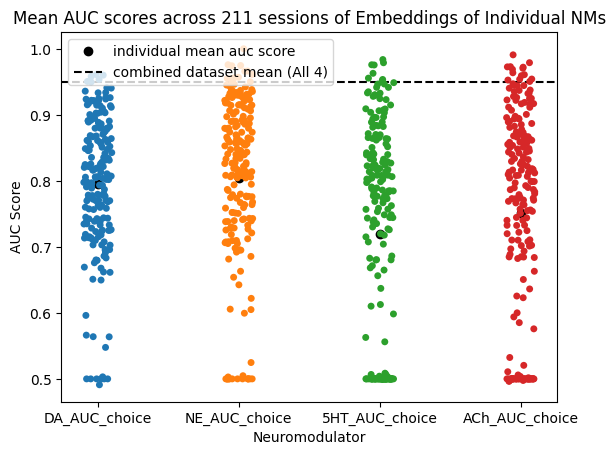

In [29]:
all_auc_mean = plot_score_ind_nms(df_all_choice)

In [30]:
df_all_reward = pickle.load(open("/Users/brian.gitahi/Desktop/AIND/CEBRA/Git/CEBRA-Demo/all_session_stats.pkl", "rb"))

In [31]:
df_all_reward

,subject_ID,ses_idx,all4_AUC,DA_AUC,NE_AUC,5HT_AUC,ACh_AUC,b4_AUC,af_AUC,ses_idx_count
0,632104,632104_2022-07-27,0.992895,0.981000,0.983636,0.846397,0.903878,0.901884,0.995210,1
1,632104,632104_2022-08-09,0.995206,0.987634,0.991667,0.874597,0.939695,0.869041,0.995206,2
2,632104,632104_2022-07-22,0.998305,0.965993,0.985014,0.824341,0.898355,0.899136,0.995830,3
3,632104,632104_2022-08-03,0.992652,0.933692,0.961290,0.806093,0.852599,0.839695,0.985305,4
4,632104,632104_2022-07-26,0.990683,0.985139,0.946766,0.824784,0.892213,0.938343,0.982033,5
...,...,...,...,...,...,...,...,...,...,...
206,632106,632106_2022-10-26,0.998529,0.969857,0.973164,0.879073,0.819647,0.873684,0.987870,12
207,632106,632106_2022-10-19,0.996454,0.975261,0.954715,0.908556,0.852717,0.834507,0.992345,13
208,632106,632106_2022-08-26,0.997788,0.973262,0.987211,0.850639,0.793034,0.813127,0.995960,14
209,632106,632106_2022-10-25,0.997229,0.977488,0.959089,0.892157,0.781093,0.842502,0.993701,15


/var/folders/zy/yd8f_r21629f1sr6zfh12jv40000gp/T/ipykernel_29895/4200864988.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  all_auc_mean = df.loc[:,df.columns[df.columns.str.contains('^(all4)', regex=True)]].mean()[0]
/var/folders/zy/yd8f_r21629f1sr6zfh12jv40000gp/T/ipykernel_29895/4200864988.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  ind_nms_mean_auc = np.array(df.loc[:,df.columns[df.columns.str.contains('^(DA|NE|5HT|ACh)', regex=True)]].mean())
/var/folders/zy/yd8f_r21629f1sr6zfh12jv40000gp/T/ipykernel_29895/4200864988.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  b4_auc_mean = df.loc[:,df.columns[df.columns.str.contains('^(b4)', regex=True)]].mean()
/var/folders/zy/yd8f_r21629f1sr6zfh12jv40000gp/T/ipyk

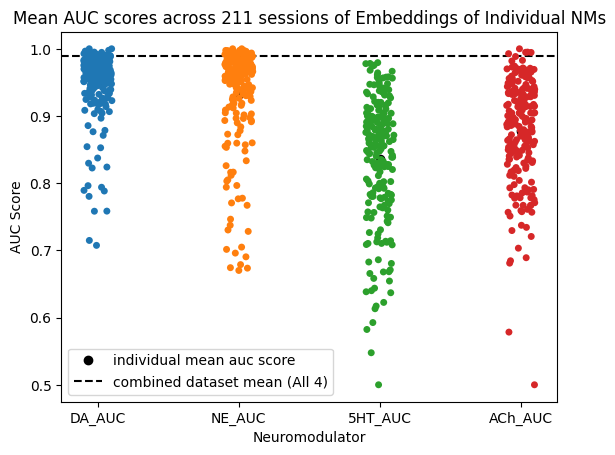

In [32]:
all_auc_mean_reward = plot_score_ind_nms(df_all_reward)